### Apprentissage profond - TD n°1 
________________

#### Exo 2 : Manipulation de datasets et visualisation

Exemple avec le dataset MNIST --> ici on le télécharge par l'intermédiaire de la librairie `torchvision`.

NB : Dans le prochain TP, on utilisera le dataset MNIST pour un problème d'apprentissage.

In [1]:
# imports
from torchvision import datasets , transforms
import matplotlib . pyplot as plt
import numpy as np
import torch


__Chargement des données__

On applique une normalisation aux images (les deux valeurs correspondent à la moyenne et à l'écart-type des valeurs des pixels). Notez qu'il n'y a qu'un seul canal, pour l'instant nous manipulons des images en nuances de gris.

In [2]:
trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.1307,), (0.3081,))]
                            )

# la première fois, les images sont téléchargées sur votre disque.
train_set = datasets.MNIST( './ data' , train = True, transform = trans, download = True)
test_set = datasets.MNIST( './ data' , train = False, transform = trans, download = True)

In [3]:
print(train_set.data.shape) # 60.000 images en 28 x 28 pixels
print(test_set.data.shape) # 10.000 images en 28 x 28 pixels

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


__Affichage__

Inspectons visuellement les données.

In [4]:
def imshow(tensor, title=None):
    img = tensor.cpu().clone()
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.5)

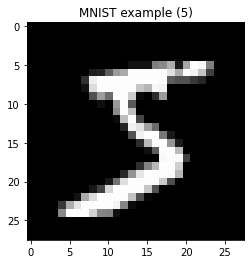

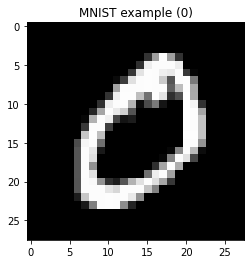

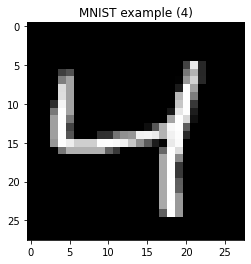

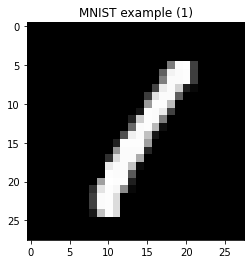

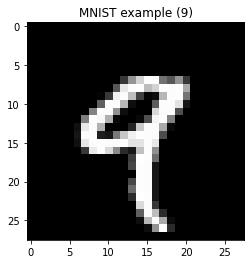

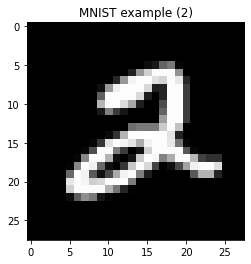

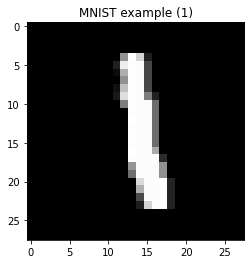

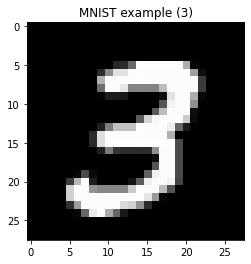

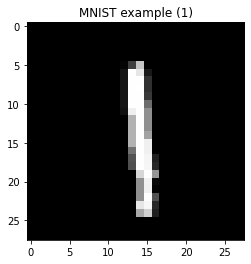

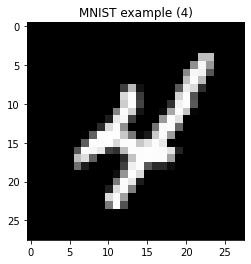

In [5]:
# Affichage des 10 premières images

plt.figure ()
for ii in range (10) :
    imshow(train_set.data[ii,:,:] , title = "MNIST example ({})".format(train_set.targets[ii]))
plt.close ()

/tmp/ipykernel_24532/931283724.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 60000 + 1) instead
  rd_range = np.random.random_integers(0, len(train_set.data), size = 10)


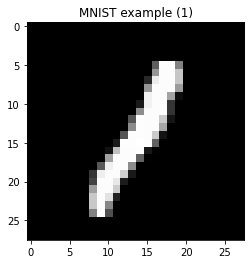

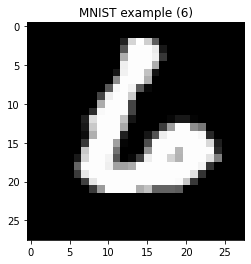

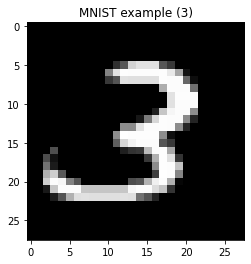

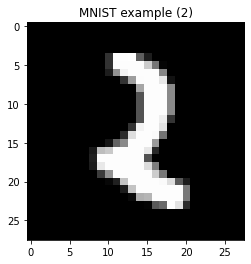

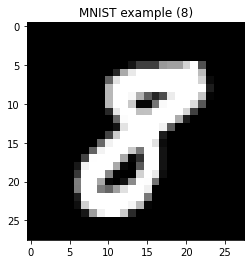

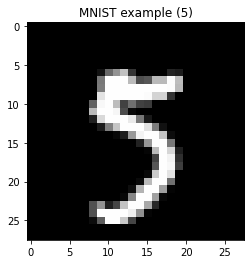

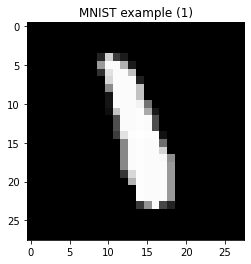

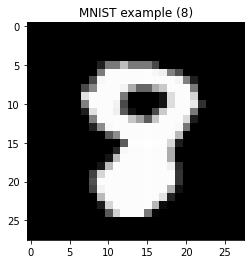

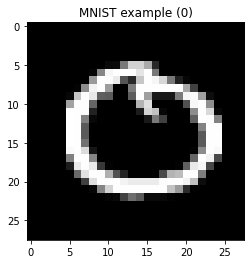

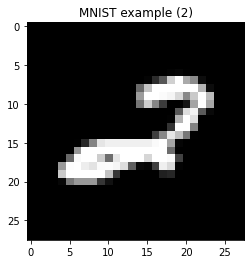

In [6]:
# Affichage de 10 images au hasard

rd_range = np.random.random_integers(0, len(train_set.data), size = 10)

plt.figure ()
for ii in rd_range :
    imshow(train_set.data[ii,:,:] , title = "MNIST example ({})".format(train_set.targets[ii]))
plt.close ()

__Surcharge couleur__

Passer d'une image noir et blanc (grayscale --> 1 seul canal) à une image couleur (RGB --> 3 canaux). Attention à l'ordre des canaux selon les librairies (openCV...) et aux conventions sur les valeurs des pixels (entre 0 et 1 ou de 0 à 255).

In [7]:
class gray2color_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset_in):
        self.dataset_in = dataset_in # dataset grayscale initial
    def __len__(self):
        return len(self.dataset_in)
    def __getitem__(self, idx):
        x = self.dataset_in.data[idx] # image d'entrée
        image = torch.zeros(3,x.shape[0],x.shape[1]) # initialisation de l'image
        label = self.dataset_in.targets[idx] # label de l'entrée
        if label<3: # 0, 1, 2 en rouge, canal 0
            image[0,:,:] = x
        elif label <7: # 3, 4, 5, 6 en vert, canal 1
            image[1,:,:] = x
        else: # 7, 8, 9 en bleu, canal 2
            image[2,:,:] = x
        image = image/255.0 # si on ne normalise pas ici, on aura un message de mise en garde "Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)."
        return (image, label)
    
# transformation
color_dataset = gray2color_dataset(train_set)

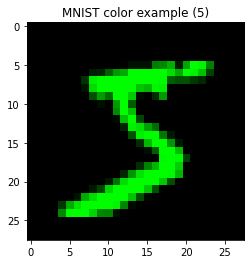

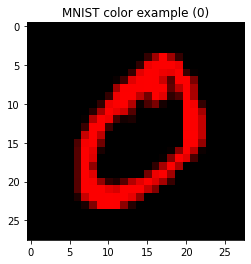

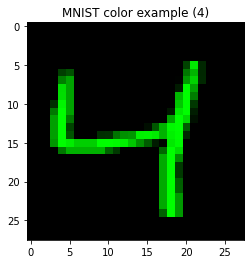

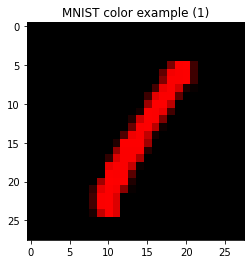

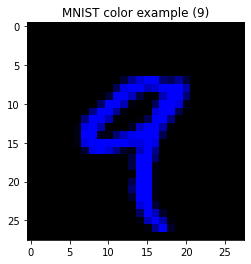

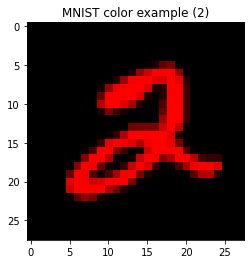

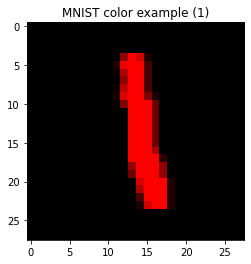

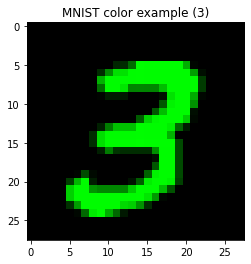

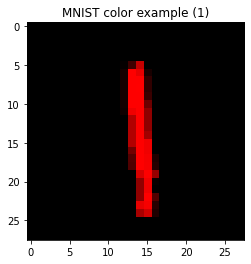

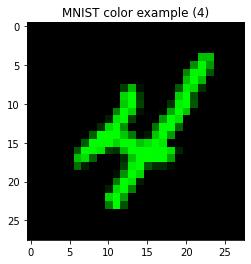

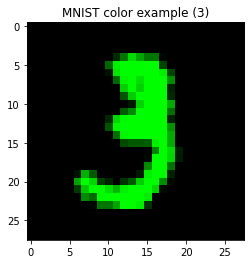

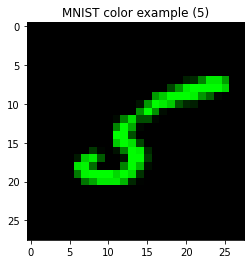

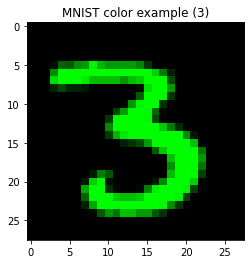

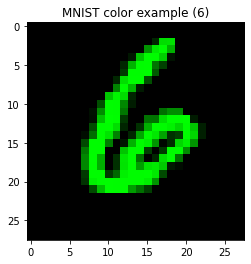

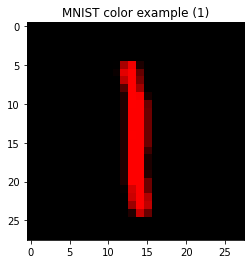

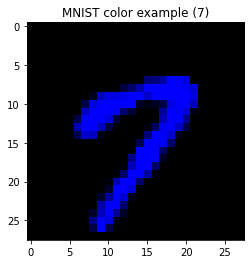

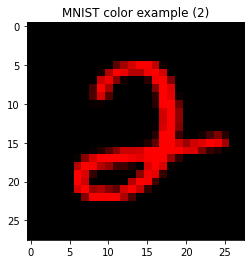

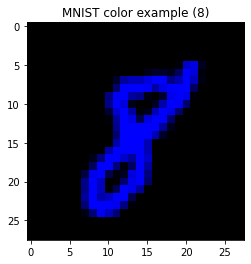

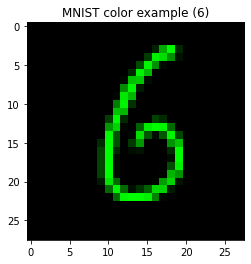

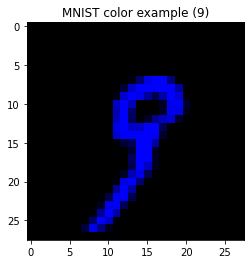

In [8]:
# affichage couleur
def imshowcolor(in_tensor, title=None):
    img = in_tensor.cpu().clone()
    img = img.squeeze()
    plt.imshow(img.permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.pause(0.5)

for ii in range(20):
    imshowcolor(color_dataset[ii][0] , title='MNIST color example ({})'.format(color_dataset[ii][1]))


__Version avec jittering__

Ajout de bruit sur les autres canaux pour chaque image. Le *color jittering* est une technique d'augmentation de données classique visant à améliorer la robustesse des modèles.

NB : on peut choisir d'ajouter du bruit sur toute l'image, ou seulement sur le chiffre.

In [9]:
# v1 : du bruit sur le chiffre uniquement

class gray2gliter_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset_in):
        self.dataset_in = dataset_in # dataset grayscale initial
    def __len__(self):
        return len(self.dataset_in)
    def __getitem__(self, idx):
        x = self.dataset_in.data[idx] # image d'entrée
        noise_a  = torch.randn(x.size())
        noise_b  = torch.randn(x.size())
        image = torch.zeros(3,x.shape[0],x.shape[1]) # initialisation de l'image
        label = self.dataset_in.targets[idx] # label de l'entrée
        if label<3: # 0, 1, 2 en rouge + bruit sur les autres canaux
            image[0,:,:] = x 
            image[1,:,:] = x.mul(noise_a)
            image[2,:,:] = x.mul(noise_b)
        elif label <7: # 3, 4, 5, 6 en vert + bruit sur les autres canaux
            image[0,:,:] = x.mul(noise_a) 
            image[1,:,:] = x
            image[2,:,:] = x.mul(noise_b)
        else: # 7, 8, 9 en bleu + bruit sur les autres canaux
            image[0,:,:] = x.mul(noise_a)
            image[1,:,:] = x.mul(noise_b)
            image[2,:,:] = x
        return (image, label)
    
gliter_dataset = gray2gliter_dataset(train_set)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


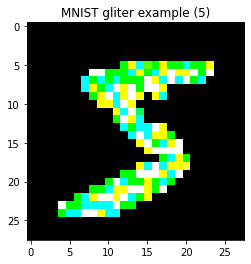

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


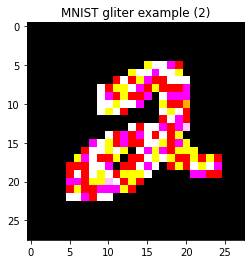

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


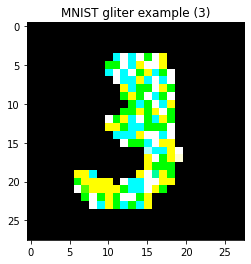

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


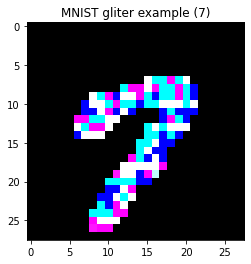

In [10]:
# affichage; NB : un message de mise en garge s'affiche comme des valeurs négatives sont présentes dans l'image du fait de l'ajout de bruit. "Clipping" : si valeur négative, le pixel est mis à 0.
for ii in range(0,20,5):
    plt.figure () 
    imshowcolor(gliter_dataset[ii][0] , title='MNIST gliter example ({})'.format(gliter_dataset[ii][1]))
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


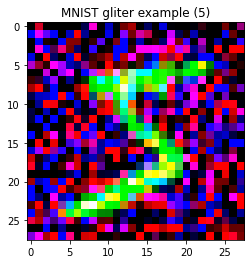

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


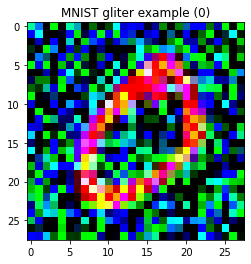

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


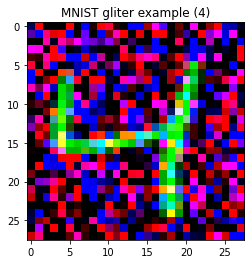

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


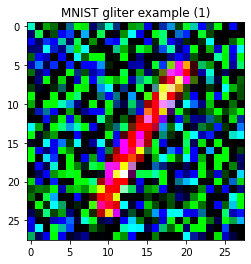

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


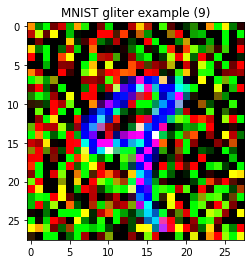

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


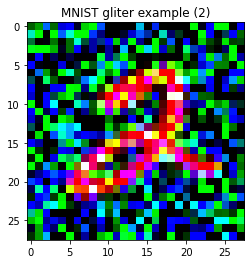

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


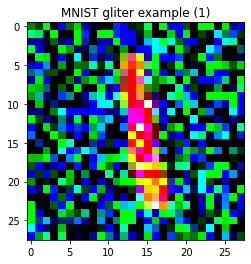

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


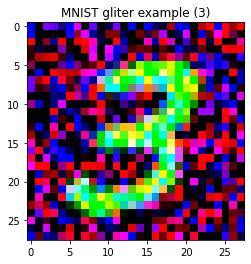

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


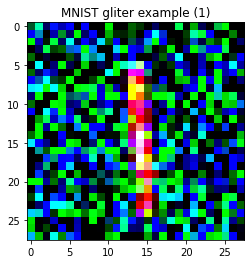

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


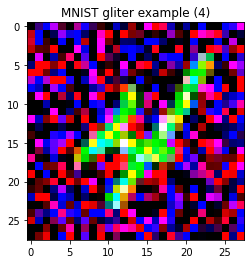

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


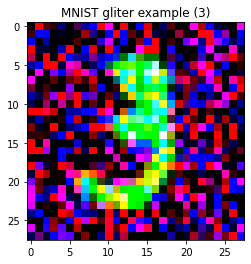

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


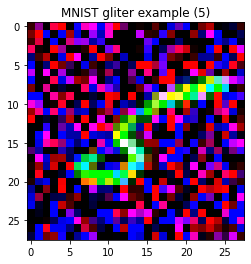

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


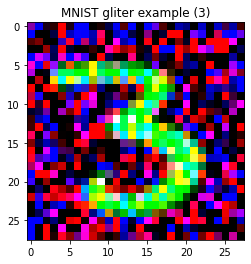

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


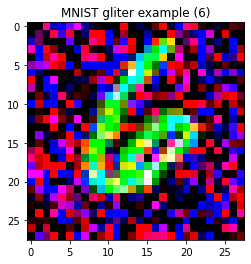

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


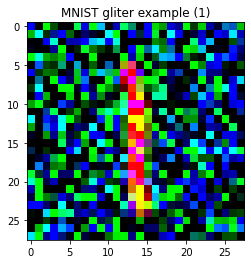

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


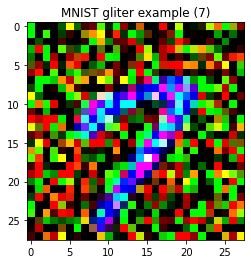

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


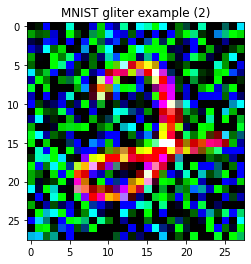

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


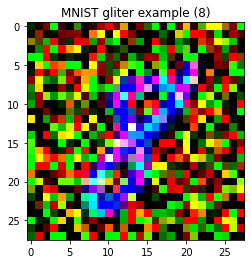

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


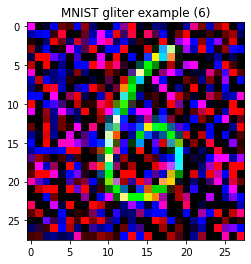

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


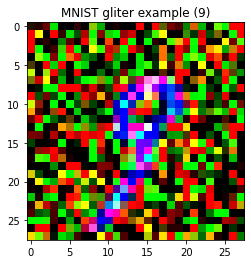

In [11]:
# v2 du bruit sur toute l'image

class gray2gliter_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset_in):
        self.dataset_in = dataset_in # dataset grayscale initial
    def __len__(self):
        return len(self.dataset_in)
    def __getitem__(self, idx):
        x = self.dataset_in.data[idx] # image d'entrée
        noise_a  = torch.randn(x.size())
        noise_b  = torch.randn(x.size())
        image = torch.zeros(3,x.shape[0],x.shape[1]) # initialisation de l'image
        label = self.dataset_in.targets[idx] # label de l'entrée
        if label<3: # 0, 1, 2 en rouge + bruit sur les autres canaux
            image[0,:,:] = x / 255.0
            image[1,:,:] = noise_a
            image[2,:,:] = noise_b
        elif label <7: # 3, 4, 5, 6 en vert + bruit sur les autres canaux
            image[0,:,:] = noise_a
            image[1,:,:] = x / 255.0
            image[2,:,:] = noise_b
        else: # 7, 8, 9 en bleu + bruit sur les autres canaux
            image[0,:,:] = noise_a
            image[1,:,:] = noise_b
            image[2,:,:] = x / 255.0
        return (image, label)
    
gliter_dataset = gray2gliter_dataset(train_set)

# affichage 
for ii in range(20):
    plt.figure ()
    imshowcolor(gliter_dataset[ii][0] , title='MNIST gliter example ({})'.format(gliter_dataset[ii][1]))
    plt.close()